# TensorFlow

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

Instructions for updating:
Colocations handled automatically by placer.



Najważniejszą rzeczą do zrozumienia jest to, że ten kod w rzeczywistości nie wykonuje żadnych obliczeń, nawet jeśli wygląda na to (szczególnie na ostatniej linii). Po prostu tworzy graf obliczeniowy. 

W rzeczywistości nawet zmienne nie zostały jeszcze zainicjowane. Aby wykonać ten graf, należy otworzyć sesję TensorFlow i użyć jej do zainicjowania zmiennych i wyliczenia $f$. 

Sesja TensorFlow zajmuje się umieszczaniem operacji na urządzeniach takich jak procesory i GPU oraz ich uruchomieniem i przechowuje wszystkie wartości zmiennych:


In [3]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
sess.close()

42


Ciągłe powtarzanie sesji **sess.run()** jest nieco uciążliwe, ale na szczęście jest lepszy sposób:

In [4]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()
    print(result)

42


Zamiast ręcznie uruchamiać inicjalizator dla każdej zmiennej, można użyć skrótu
Funkcja **global_variables_initializer()**. Zauważ, że nie wykonuje on natychmiastowej nitlizacji, lecz tworzy na wykresie węzeł, który inicjalizuje wszystkie zmienne podczas działania:

In [5]:
init = tf.global_variables_initializer() # prepare an init node
with tf.Session() as sess:
    init.run() # actually initialize all the variables
    result = f.eval()
    print(result)

42


Program TensorFlow dzieli się zazwyczaj na dwie części: pierwsza część tworzy graf obliczeniowy (nazywa się to fazą konstrukcyjną), a druga część uruchamia go (jest to faza wykonania).

# Tworzeniw grfów
Każdy utworzony węzeł jest automatycznie dodawany do domyślnego grafu:

In [6]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

W większości przypadków jest to w porządku, ale czasami możesz chcieć zarządzać wieloma niezależnymi grafami. Możesz to zrobić, tworząc nowy graf i tymczasowo ustawiając go jako domyślny wykres wewnątrz bloku:

In [7]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

x2.graph is graph

True

In [8]:
x2.graph is tf.get_default_graph()

False

W Jupyter (lub w powłoce Pythona) często używa się tych samych poleceń więcej niż raz podczas eksperymentowania. W rezultacie może pojawić się domyślny wykres zawierający wiele zduplikowanych węzłów. Jednym z rozwiązań jest ponowne uruchomienie jądra Jupytera (lub powłoki Pythona), ale wygodniejszym rozwiązaniem jest przywrócenie domyślnego wykresu poprzez uruchomienie **tf.reset_default_graph()**.

Podczas inicjalizacji węzła TensorFlow automatycznie określa zestaw węzłów, od których zależy i najpierw inicjalizuje te węzły. Rozważmy na przykład następujący kod:

In [9]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3
with tf.Session() as sess:
    print(y.eval()) 
    print(z.eval()) 

10
15


# Linear Regression with TensorFlow

Weźmy dane housing oraz wykonajmy regresję liniową za pomocą rozwiązania układu równań liniowych.

In [10]:
import numpy as np
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
m, n = housing.data.shape
print(m, n)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
housing_data_scaled=scaler.fit_transform(housing.data)

20640 8


Za pomocą NumPy wyglądało by to tak:

In [11]:
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing_data_scaled]
print(housing_data_plus_bias.shape)

(20640, 9)


In [12]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)
theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print(theta_numpy)

[[ 2.06855817]
 [ 0.8296193 ]
 [ 0.11875165]
 [-0.26552688]
 [ 0.30569623]
 [-0.004503  ]
 [-0.03932627]
 [-0.89988565]
 [-0.870541  ]]


Za pomocą Scikit-Learn można to zrobić tak:

In [13]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_data_scaled, housing.target.reshape(-1, 1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[ 2.06855817]
 [ 0.8296193 ]
 [ 0.11875165]
 [-0.26552688]
 [ 0.30569623]
 [-0.004503  ]
 [-0.03932627]
 [-0.89988565]
 [-0.870541  ]]


W tensorflow możemy to zrobić tak

In [14]:
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")

In [15]:
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
with tf.Session() as sess:
    theta_value = theta.eval()
    print(theta_value)

[[ 2.0685582 ]
 [ 0.82961833]
 [ 0.11875167]
 [-0.2655248 ]
 [ 0.30569422]
 [-0.00450306]
 [-0.03932625]
 [-0.8998866 ]
 [-0.87054205]]


# Przykład.
Wykonaj regresje na poniższych danych oraz narysuj wykres

In [16]:
import numpy as np
import tensorflow as tf
data = np.loadtxt("data/life_satisfaction.csv",
                  dtype=np.float32,
                  delimiter=",",
                  skiprows=1,
                  usecols=[1, 2])
X_train = data[:, 0:1] / 10000 # feature scaling
y_train = data[:, 1:2]

import matplotlib.pyplot as plt

plt.plot(X_train, y_train, "bo")
plt.show()
print(X_train.shape)

<Figure size 640x480 with 1 Axes>

(29, 1)


In [17]:
data_plus_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
data_plus_bias_m, data_plus_bias_n = data_plus_bias.shape
print(data_plus_bias, data_plus_bias_m)

X = tf.constant(data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(y_train.reshape(-1, 1), dtype=tf.float32, name="y")

XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
with tf.Session() as sess:
    theta_value = theta.eval()
    print(theta_value)
    

[[1.         0.90549141]
 [1.         0.94373721]
 [1.         1.22398937]
 [1.         1.24953341]
 [1.         1.59917367]
 [1.         1.72880816]
 [1.         1.80642867]
 [1.         1.9121592 ]
 [1.         2.07324815]
 [1.         2.58647203]
 [1.         2.71951962]
 [1.         2.9866581 ]
 [1.         3.24855447]
 [1.         3.53433371]
 [1.         3.70448899]
 [1.         3.76750088]
 [1.         4.01066351]
 [1.         4.09965134]
 [1.         4.19739866]
 [1.         4.33319616]
 [1.         4.36031151]
 [1.         4.37240314]
 [1.         4.37706852]
 [1.         4.98662663]
 [1.         5.08545828]
 [1.         5.09618616]
 [1.         5.13507414]
 [1.         5.21141624]
 [1.         5.58052015]] 29
[[4.853051  ]
 [0.49115434]]


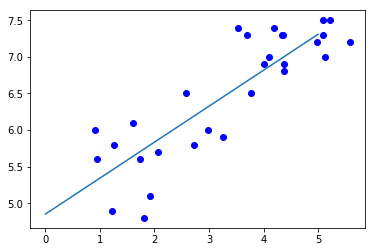

In [18]:
plt.plot(X_train, y_train, "bo")
#plt.plot([0, 60000], [theta_value[1][0], w[0][0] * (60000 / 10000) + theta_value[1][0]])
plt.plot([0, 5], [theta_value[0][0],theta_value[1][0]*5+theta_value[0][0]])
plt.show()

# Implementing Gradient Descent
Możemy zminimalizować funkcję kosztu gradientowo wykorzystując gradient:
```python
gradients = 2/m * tf.matmul(tf.transpose(X), error)
```

In [19]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    print(best_theta)

Epoch 0 MSE = 2.7544265
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.5727803
Epoch 300 MSE = 0.5585008
Epoch 400 MSE = 0.54907006
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.5373791
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.53124255
Epoch 900 MSE = 0.5293705
[[ 2.0685523e+00]
 [ 7.7407807e-01]
 [ 1.3119239e-01]
 [-1.1784508e-01]
 [ 1.6477816e-01]
 [ 7.4407656e-04]
 [-3.9194509e-02]
 [-8.6135668e-01]
 [-8.2347983e-01]]


# Przykład.
Wykonaj regresje powyższym sposobem na danych life_satisfaction.csv oraz narysuj wykres:

In [20]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01
print(data_plus_bias_n)

X = tf.constant(data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(y_train.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([data_plus_bias_n, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/data_plus_bias_m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    print(best_theta)

2
Epoch 0 MSE = 19.612455
Epoch 100 MSE = 1.3545243
Epoch 200 MSE = 0.8315496
Epoch 300 MSE = 0.54158574
Epoch 400 MSE = 0.3808158
Epoch 500 MSE = 0.29167664
Epoch 600 MSE = 0.24225357
Epoch 700 MSE = 0.21485056
Epoch 800 MSE = 0.19965717
Epoch 900 MSE = 0.19123317
[[4.660542  ]
 [0.54031867]]


Możemy też użyć gradientu wyliczonego za pomocą automatycznego różniczkowania
```python
gradients = tf.gradients(mse, [theta])[0]
```

In [21]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

gradients = tf.gradients(mse, [theta])[0]

training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.7544265
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.5727804
Epoch 300 MSE = 0.5585008
Epoch 400 MSE = 0.54907006
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.5373791
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.53124243
Epoch 900 MSE = 0.5293705
Best theta:
[[ 2.0685525e+00]
 [ 7.7407801e-01]
 [ 1.3119237e-01]
 [-1.1784505e-01]
 [ 1.6477814e-01]
 [ 7.4407156e-04]
 [-3.9194506e-02]
 [-8.6135691e-01]
 [-8.2347995e-01]]


# Przykład.
Wykonaj regresje powyższym sposobem na danych life_satisfaction.csv oraz narysuj wykres:

In [22]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01
print(data_plus_bias_n)

X = tf.constant(data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(y_train.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([data_plus_bias_n, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

gradients = tf.gradients(mse, [theta])[0]

training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    print(best_theta)

2
Epoch 0 MSE = 19.612455
Epoch 100 MSE = 1.3545243
Epoch 200 MSE = 0.8315496
Epoch 300 MSE = 0.54158574
Epoch 400 MSE = 0.3808158
Epoch 500 MSE = 0.29167664
Epoch 600 MSE = 0.24225357
Epoch 700 MSE = 0.21485056
Epoch 800 MSE = 0.19965717
Epoch 900 MSE = 0.19123317
[[4.660542  ]
 [0.54031867]]


## Ciekwaostka

Jak można znaleźć pochodne cząstkowe poniższej funkcji w odniesieniu do a i b?

In [23]:
def my_func(a, b):
    z = 0
    for i in range(100):
        z = a * np.cos(z + i) + z * np.sin(b - i)
    return z

my_func(0.2, 0.3)

-0.21253923284754916

In [24]:
tf.reset_default_graph()

a = tf.Variable(0.2, name="a")
b = tf.Variable(0.3, name="b")
z = tf.constant(0.0, name="z0")
for i in range(100):
    z = a * tf.cos(z + i) + z * tf.sin(b - i)

grads = tf.gradients(z, [a, b])
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    print(z.eval())
    print(sess.run(grads))

-0.21253741
[-1.1388494, 0.19671395]


## Gradient Descent Optimizer

Możemy również użyć wbudowanej funkcji do optymalizacji

```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)
```

In [25]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)


init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.7544265
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.5727804
Epoch 300 MSE = 0.5585008
Epoch 400 MSE = 0.54907006
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.5373791
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.53124243
Epoch 900 MSE = 0.5293705
Best theta:
[[ 2.0685525e+00]
 [ 7.7407801e-01]
 [ 1.3119237e-01]
 [-1.1784505e-01]
 [ 1.6477814e-01]
 [ 7.4407156e-04]
 [-3.9194506e-02]
 [-8.6135691e-01]
 [-8.2347995e-01]]


Jest wiele różnych metod optymalizacji

In [26]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")


optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 2.7544265
Epoch 100 MSE = 0.52731603
Epoch 200 MSE = 0.5244147
Epoch 300 MSE = 0.52432823
Epoch 400 MSE = 0.5243219
Epoch 500 MSE = 0.52432114
Epoch 600 MSE = 0.524321
Epoch 700 MSE = 0.524321
Epoch 800 MSE = 0.524321
Epoch 900 MSE = 0.524321
Best theta:
[[ 2.068558  ]
 [ 0.8296167 ]
 [ 0.11875118]
 [-0.26552182]
 [ 0.30569196]
 [-0.00450316]
 [-0.03932617]
 [-0.8998903 ]
 [-0.8705453 ]]


# Przykład.
Wykonaj regresje powyższym sposobem na danych life_satisfaction.csv oraz narysuj wykres:

In [27]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(y_train.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([data_plus_bias_n, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")


optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 19.612455
Epoch 100 MSE = 0.18110894
Epoch 200 MSE = 0.18075033
Epoch 300 MSE = 0.18075036
Epoch 400 MSE = 0.18075036
Epoch 500 MSE = 0.18075036
Epoch 600 MSE = 0.18075033
Epoch 700 MSE = 0.18075036
Epoch 800 MSE = 0.18075036
Epoch 900 MSE = 0.18075033
Best theta:
[[4.853055  ]
 [0.49115396]]


# Warstwa typu placeholder
Warstwa typu placeholder pozwala na dynamiczne dostarczanie danych

In [28]:
tf.reset_default_graph()

A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)
print(B_val_2)

[[6. 7. 8.]]
[[ 9. 10. 11.]
 [12. 13. 14.]]


W naszym przypadku mamy:

In [29]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [30]:
n_epochs = 100
batch_size = 100
n_batches = int(np.ceil(m / batch_size))


def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    X_batch = housing_data_plus_bias[indices] 
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            print("Epoch", epoch, "MSE =", sess.run( mse, feed_dict={X: X_batch, y: y_batch}) )   

    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")
    
print("Best theta:")
print(best_theta)    

Epoch 0 MSE = 0.50248396
Epoch 10 MSE = 0.561448
Epoch 20 MSE = 0.5520323
Epoch 30 MSE = 0.5906025
Epoch 40 MSE = 0.34487298
Epoch 50 MSE = 0.44054422
Epoch 60 MSE = 0.5481226
Epoch 70 MSE = 0.4481215
Epoch 80 MSE = 0.58561224
Epoch 90 MSE = 0.38659617
Best theta:
[[ 2.0544672 ]
 [ 0.8297011 ]
 [ 0.10713524]
 [-0.3107482 ]
 [ 0.24564512]
 [-0.00222411]
 [-0.01061386]
 [-0.8912159 ]
 [-0.875248  ]]


In [31]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval() 

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


In [32]:
print(best_theta_restored)

[[ 2.0544672 ]
 [ 0.8297011 ]
 [ 0.10713524]
 [-0.3107482 ]
 [ 0.24564512]
 [-0.00222411]
 [-0.01061386]
 [-0.8912159 ]
 [-0.875248  ]]


# Przykład.
Proszę wykonać regresję za pomocą sieci neuronowej złożonej z dwóch warstw fully connected z warstwą aktywacji relu na poniższych danych.

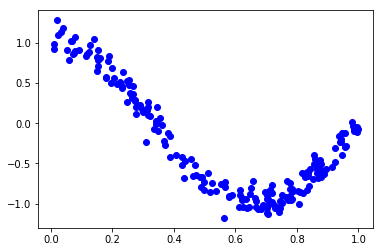

In [33]:
true_fun = lambda X: np.cos(1.5 * np.pi * X)
n_samples=200
X_train = np.sort(np.random.rand(n_samples))
y_train = true_fun(X_train) + np.random.randn(n_samples) * 0.1
X_train=np.vstack(X_train)
y_train=np.vstack(y_train)
import matplotlib.pyplot as plt

plt.plot(X_train, y_train, "bo")
plt.show()

In [34]:
tf.reset_default_graph()

n_inputs = 1
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 1

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y")

Wykorzystamy sieć typu fully_connected z funkcją aktywacji relu.

In [35]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([n_neurons]), name="biases")
        z = tf.matmul(X, W) + b
        if activation=="relu":
            return tf.nn.relu(z)
        else:
            return z

In [36]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
    hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
    hidden3 = neuron_layer(hidden2, n_hidden2, "hidden3", activation="relu")
    hidden4 = neuron_layer(hidden3, n_hidden2, "hidden4", activation="relu")
    y_pred = neuron_layer(hidden4, n_outputs, "outputs")
    
with tf.name_scope("loss"):
    error = y_pred - y
    loss = tf.reduce_mean(tf.square(error), name="mse")
        
learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)    
    

In [37]:
x_dom = np.vstack(np.arange(0,1,0.01))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 4000
batch_size = 50
n_batches = int(np.ceil(len(X_train) / batch_size))

def fetch_batch(epoch, batch_index, batch_size, X,  y):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(X.shape[0], size=batch_size)  # not shown
    X_batch = X[indices] # not shown
    y_batch = y[indices] # not shown
    return X_batch, y_batch

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size, X_train, y_train)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            acc_train = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print("Epoch", epoch, "mse:", acc_train)#, "Val accuracy:", acc_val)
    x_dom_pred = y_pred.eval(feed_dict={X: x_dom})
    #save_path = saver.save(sess, "./my_model_final.ckpt")

Epoch 0 mse: 0.22802529
Epoch 100 mse: 0.17795646
Epoch 200 mse: 0.1979255
Epoch 300 mse: 0.1399532
Epoch 400 mse: 0.16681623
Epoch 500 mse: 0.11882894
Epoch 600 mse: 0.16406107
Epoch 700 mse: 0.090657204
Epoch 800 mse: 0.0980998
Epoch 900 mse: 0.13303977
Epoch 1000 mse: 0.10809727
Epoch 1100 mse: 0.1026908
Epoch 1200 mse: 0.07555953
Epoch 1300 mse: 0.05516101
Epoch 1400 mse: 0.062633045
Epoch 1500 mse: 0.037232086
Epoch 1600 mse: 0.020967161
Epoch 1700 mse: 0.021629144
Epoch 1800 mse: 0.021809464
Epoch 1900 mse: 0.020379685
Epoch 2000 mse: 0.019967109
Epoch 2100 mse: 0.012829144
Epoch 2200 mse: 0.019265044
Epoch 2300 mse: 0.016895628
Epoch 2400 mse: 0.014886848
Epoch 2500 mse: 0.011932412
Epoch 2600 mse: 0.015951285
Epoch 2700 mse: 0.011531488
Epoch 2800 mse: 0.009108945
Epoch 2900 mse: 0.008479824
Epoch 3000 mse: 0.012500047
Epoch 3100 mse: 0.014527776
Epoch 3200 mse: 0.009691443
Epoch 3300 mse: 0.011890395
Epoch 3400 mse: 0.009744742
Epoch 3500 mse: 0.014735738
Epoch 3600 mse: 0.012

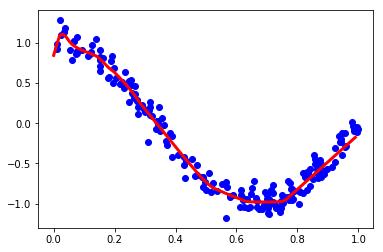

In [38]:
import matplotlib.pyplot as plt

plt.plot(X_train, y_train, "bo")
plt.plot(x_dom, x_dom_pred, color='red',linewidth=3)
plt.show()

# Zad.
Proszę wykonać regresję za pomocą sieci neuronowej złożonej z dwóch warstw fully connected z warstwą aktywacji relu na danych 
housing .

In [ ]:
X_data = housing_data_plus_bias
y_data = housing.target.reshape(-1, 1)

tf.reset_default_graph()

n_inputs = housing_data_plus_bias.shape
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 1

X = tf.placeholder(tf.float32, shape=(None, ) + X_data.shape[1:], name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", activation="relu")
    hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", activation="relu")
    y_pred = neuron_layer(hidden2, n_outputs, "outputs")
    
with tf.name_scope("loss"):
    error = y_pred - y
    loss = tf.reduce_mean(tf.square(error), name="mse")
        
learning_rate = 0.001

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)    

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 4000
batch_size = 50
n_batches = int(np.ceil(len(X_data) / batch_size))

def fetch_batch(epoch, batch_index, batch_size, X,  y):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(X.shape[0], size=batch_size)  # not shown
    X_batch = X[indices] # not shown
    y_batch = y[indices] # not shown
    return X_batch, y_batch

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size, X_data, y_data)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 100 == 0:
            acc_train = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print("Epoch", epoch, "mse:", acc_train)#, "Val accuracy:", acc_val)
#     x_dom_pred = y_pred.eval(feed_dict={X: x_dom})
    #save_path = saver.save(sess, "./my_model_final.ckpt")    

Epoch 0 mse: 0.92661965
Epoch 100 mse: 0.33652222
Epoch 200 mse: 0.38780776
Epoch 300 mse: 0.41274858
Epoch 400 mse: 0.16538653
Epoch 500 mse: 0.0876539
Epoch 600 mse: 0.3090452
Epoch 700 mse: 0.22903347
Epoch 800 mse: 0.15330356
Epoch 900 mse: 0.113221094
Epoch 1000 mse: 0.20646761
Epoch 1100 mse: 0.24477945
Epoch 1200 mse: 0.14134505
Epoch 1300 mse: 0.10051693
Epoch 1400 mse: 0.18688646
Epoch 1500 mse: 0.16668461
Epoch 1600 mse: 0.19449323
Epoch 1700 mse: 0.21223758
Epoch 1800 mse: 0.15232989
Epoch 1900 mse: 0.20597664
Epoch 2000 mse: 0.15536787
Epoch 2100 mse: 0.07575783
Epoch 2200 mse: 0.11529293
Epoch 2300 mse: 0.15841357
Epoch 2400 mse: 0.12369412
Epoch 2500 mse: 0.14320165
